### 11.1
给定一组平面上的点:

$$x^\left( 1 \right) = (1,1),x^\left( 2 \right) = (0 ,1),x^\left( 3 \right) = ( -1 ,1),x^\left( 4 \right) = ( 2 ,0 ),x^\left( 5 \right) = ( -1 ,0 )$$

考察平面上的两个中心：

$$c^\left( 1 \right) = (0,0),c^\left( 2 \right) = (1,0)$$

请用k均值算法将 
$$ x^{\left( 1 \right)},x^{\left( 2 \right)},x^{\left( 3 \right)},...,x^{\left( 5 \right)}$$ 

分别归入距离最近的中心，并计算出新中心的位置。



In [1]:
import numpy as np

class KMeans:
    def __init__(self, n_clusters = 1, max_iter = 50, random_state=0):
        self.k = n_clusters
        self.max_iter = max_iter
        np.random.seed(random_state)
         
    def assign_to_centers(self, centers, X):
        assignments = []
        for i in range(len(X)):
            distances = [np.linalg.norm(X[i] - centers[j], 2) for j in range(self.k)] 
            assignments.append(np.argmin(distances))
        return assignments 
    
    def adjust_centers(self, assignments, X):
        new_centers = []
        for j in range(self.k):
            cluster_j = [X[i] for i in range(len(X)) if assignments[i] == j]
            new_centers.append(np.mean(cluster_j, axis=0))
        return new_centers  
            
    def fit_transform(self, X, centers):
        for iter in range(self.max_iter):
            assignments = self.assign_to_centers(centers, X)
            centers = self.adjust_centers(assignments, X)
        return np.array(centers), np.array(assignments)
model = KMeans(n_clusters=2)
X = np.array([[1,1], [0,1], [-1,1], [2,0], [-1,0]])
centers = [[0,0],[1.0]]
model.fit_transform(X, centers)

(array([[-0.66666667,  0.66666667],
        [ 1.5       ,  0.5       ]]),
 array([1, 0, 0, 1, 0], dtype=int64))

### 11.2 

考察9条一维数据 $$x^\left( i \right) = i^2,i=1,2,3,...,9$$

用合并聚类算法将这组数据聚成三类.

In [2]:
import numpy as np
import heapq

class AgglomerativeClustering:
    def __init__(self, n_clusters = 1):
        self.k = n_clusters
            
    def fit_transform(self, X):
        m, n = X.shape
        C, centers = {}, {}
        assignments = np.zeros(m)
        for id in range(m):
            C[id] = [id]
            centers[id] = X[id]
            assignments[id] = id 
        H = []
        for i in range(m):
            for j in range(i+1, m):
                d = np.linalg.norm(X[i] - X[j], 2)
                heapq.heappush(H, (d, [i, j]))     
        new_id = m 
        while len(C) > self.k:
            distance, [id1, id2] = heapq.heappop(H)
            if id1 not in C or id2 not in C:
                continue
            C[new_id] = C[id1] + C[id2]
            for i in C[new_id]:
                assignments[i] = new_id
            del C[id1], C[id2], centers[id1], centers[id2]
            new_center = sum(X[C[new_id]]) / len(C[new_id])
            for id in centers:
                center = centers[id]
                d = np.linalg.norm(new_center - center, 2)
                heapq.heappush(H, (d, [id, new_id]))
            centers[new_id] = new_center
            new_id += 1
        return np.array(list(centers.values())), assignments

In [6]:
X = np.array([i**2 for i in range(1,10)]).reshape(-1,1)
agg = AgglomerativeClustering(n_clusters=3)
agg.fit_transform(X)

(array([[42.5],
        [11. ],
        [72.5]]),
 array([13., 13., 13., 13., 13., 12., 12., 14., 14.]))

### 11.3

分别用DBSCAN算法和合并聚类算法对例 11.1 中的墨渍数据集进行聚类。

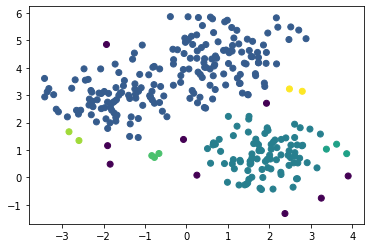

In [9]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

class DBSCAN:
    def __init__(self, eps = 0.5, min_sample = 5):
        self.eps = eps
        self.min_sample = min_sample
            
    def get_neighbors(self, X, i):
        if i in self.neighbors:
            return self.neighbors[i]
        m = len(X)
        distances = [np.linalg.norm(X[i] - X[j], 2) for j in range(m)]
        neighbors_i = [j for j in range(m) if distances[j] < self.eps]
        self.neighbors[i] = neighbors_i
        return neighbors_i
    
    def grow_cluster(self, X, i, neighbors_i, id):
        self.assignments[i] = id
        queue = deepcopy(neighbors_i)
        t = 0
        while t < len(queue):
            j = queue[t]
            if self.assignments[j] == -1:
                self.assignments[j] = id
            elif self.assignments[j]== 0:
                self.assignments[j] = id
                neighbors_j = self.get_neighbors(X, j)
                if len(neighbors_j) > self.min_sample:
                    queue += neighbors_j
            t += 1
                 
    def fit_transform(self, X):
        self.assignments = np.zeros(len(X))
        self.neighbors = {}
        id = 1
        for i in range(len(X)):
            if self.assignments[i] != 0:
                continue
            neighbors_i = self.get_neighbors(X, i)
            if len(neighbors_i) < self.min_sample:
                self.assignments[i] = -1
            else:
                self.grow_cluster(X, i, neighbors_i, id)
                id += 1
        return self.assignments
        
    
X, y = make_blobs(n_samples=300, centers=3, random_state=0, cluster_std=0.8)     
model = DBSCAN(eps = 0.5, min_sample = 2)
db_assignments = model.fit_transform(X)
plt.scatter(X[:,0], X[:,1], c=db_assignments)
plt.show()

### 11.4 

请用合并聚类算法,对例11.3中的同心圆数据集进行聚类。

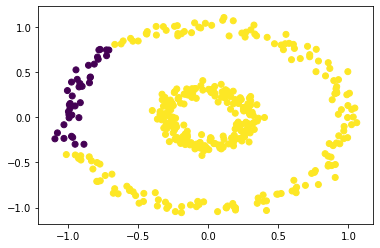

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

np.random.seed(0)        
X, y = make_circles(n_samples=400, factor=.3, noise=.05)


agg = AgglomerativeClustering(n_clusters=2)
_, agg_assignments = agg.fit_transform(X)

plt.scatter(X[:, 0], X[:,1], c = agg_assignments)
plt.show()

### 11.5

分别用k均值算法、合并聚类算法与DBSCAN算法对鸢尾花数据集进行聚类，
并检验聚类的结果是否与数据的标签一致。

### 11.6   小批量k均值算法。

    k均值算法的计算时间复杂度为O(mnkN)。其中，m是训练数据的个数。由此可见，
    当m较大时，k均值算法需要较长的运行时间。因此，许多实际问题都采用k均值算法的一
    个变形一小批量 k均值算法。


    小批量k均值算法分N轮循环进行。在每一轮循环中，都进行样本归类和中心调整两
    步。在循环开始前,随机选取k个中心。在每一轮 循环中，算法读取b条训练数据采样。其
    中，b是算法参数，由算法设计者指定。在样本归类这一一步中，将这b条数据中的每一条数据
    归人距其最近的中心。在中心调整这一步中 ,将每个中心调整为两部分点的平均值，第一部
    分是当前b条数据中归人该中心的点，第二部分是所有在以往的循环中被归人该中心的点，
    在N轮循环之后算法返回得到的k个中心。

(1)分析小批量k均值算法的时间复杂度。

(2)实现小批量k均值算法。

(3)分别用k均值算法和小批量k均值算法对手写数字识别数据集进行聚类，检验聚类的结果是否与数据的标签一致，并比较两个算法的运行时间。

### 11.7  均值漂移算法


均值漂移算法是一个基于划分的聚类算法。
给定一组数据，均值漂移算法通过迭代来调整每个数据点的位置，使得每一点都朝着该点领域内密度较高的区域漂移，以完成聚类，图 11.21 是均值漂移算法的聚类过程演示。在图 11.21 中，通过将每个点朝密度较高的区域漂移，所有的点逐渐聚成了3类。
    
以下是均值漂移算法的具体描述。
    
给定m条数据
 $$x^{\left( 1 \right)},x^{\left( 2 \right)},x^{\left( 3 \right)},...,x^{\left( m \right)}\in R^n$$
    
算法分N轮循环进行。在每一轮的循环当中，算法首先为每一点$x^{\left( i \right)}$,计算它的$\varepsilon$领域


$$N_{i} = \{j:||x^{\left( j \right)} - x^{\left( i \right)}|| \leqslant \varepsilon,1 \leqslant j \leqslant m  \} , 1\leqslant i \leqslant m $$

其中,$\varepsilon$ 是一个算法参数，由算法设计者指定。然后，对每个 $1\leqslant i \leqslant m$,计算

$$ z^{\left( i \right)} = \frac{\sum\limits_{j \in N_i} K (x^{\left( i \right)},x^{\left( j \right)})\bullet x^{\left( j \right)}}{\sum\limits_{j \in N_i} K (x^{\left( i \right)},x^{\left( j \right)})} $$

其中，K($\bullet$,$\bullet$)是一个核函数，一般取为高斯核函数


$$K(x,z) = e ^ {- \frac{||x-z||^2}{2\sigma^2}} ,  
x,z \in R ^n$$
  
函数中的 $\sigma$ 是一个算法参数。最后，对每一个 $1\leqslant i \leqslant m$,调整$x^{\left( i \right)}$的位置至$z^{\left( i \right)}$,即 $x^{\left( i \right)} \gets z^{\left( i \right)} $


(1)实现上述均值漂移算法。


(2) 以下 11.22 中的程序用于生成图 11.21（a）中的数据采样，请基于 11.22 中的程序，采用（1）中实现的均值漂移算法，
调试合适的算法参数 $\sigma$ 和 $\varepsilon$ ,完成数据聚类。


![11.21](11.21_ab.png)

&#8195;&#8195;&#8195;&#8195;&#8195;&#8195;&#8195;（a）  &#8195; &#8195;&#8195;&#8195;&#8195;&#8195;&#8195;&#8195;&#8195;&#8195;&#8195;&#8195;&#8195;  &#8195;&#8195;&#8195;&#8195;&#8195;（b）

![11.21](11.21_cd.png)

&#8195;&#8195;&#8195;&#8195;&#8195;&#8195;&#8195;（c）  &#8195; &#8195;&#8195;&#8195;&#8195;&#8195;&#8195;&#8195;&#8195;&#8195;&#8195;&#8195;&#8195;  &#8195;&#8195;&#8195;&#8195;&#8195;（d）

![11.21](11.21_ef.png)

&#8195;&#8195;&#8195;&#8195;&#8195;&#8195;&#8195;（e）  &#8195; &#8195;&#8195;&#8195;&#8195;&#8195;&#8195;&#8195;&#8195;&#8195;&#8195;&#8195;&#8195;  &#8195;&#8195;&#8195;&#8195;&#8195;（f）


    图11.21 均值漂移过程

In [3]:
#图11.22  生成图11.21(a)中的数据采样
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=100, centers=3,random_state=0, cluster_std=0.4)
